References

1. https://cs231n.github.io/neural-networks-2/#reg
2. https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/DL2/Bayesian_Neural_Networks/dl2_bnn_tut2_student_with_answers.html

In [1]:
### Regular Dropout

import torch
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd

import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Use GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


In [2]:
from tueplots import bundles
plt.rcParams.update(bundles.beamer_moml())


# Also add despine to the bundle using rcParams
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

# Increase font size to match Beamer template
plt.rcParams['font.size'] = 16
# Make background transparent
plt.rcParams['figure.facecolor'] = 'none'

Inspired from: https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/DL2/Bayesian_Neural_Networks/dl2_bnn_tut2_student_with_answers.html

In [3]:
def get_simple_data_train():
    x = torch.linspace(-2, 4, 100)
    x = torch.hstack([x, torch.linspace(6, 8, 100)])
    f = lambda x: torch.sin(x)
    eps = torch.randn_like(x) * 0.1
    f_x = f(x) 
    y_train = f_x + eps
    x_train = x[:, None]
    return x_train, y_train, f

In [4]:
def plot_generic(add_to_plot=None):
    fig, ax = plt.subplots()

    plt.xlabel("X",)
    plt.ylabel("Y",)

    x_train, y_train, true_func = get_simple_data_train()
    
    x_all = torch.linspace(-2, 8, 1000)

    ax.plot(x_train, y_train, 'C0', marker='o', ms= 4, linestyle='none', alpha=0.2, label='Observations')
    ax.plot(x_all, true_func(x_all), 'C1', linewidth=1, label="true function")
    if add_to_plot is not None:
        add_to_plot(ax)

    plt.legend(loc=4, frameon=False)
    plt.show()

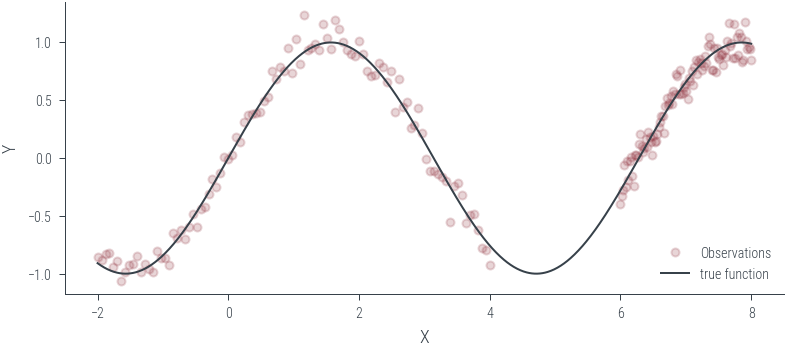

In [5]:
plot_generic()

In [6]:
# Define a simple MLP without using nn.Linear

input_dim = 1

hidden_l1_dim = 100
hidden_l2_dim = 50


def init_params():
    W1 = nn.Parameter(torch.randn(input_dim, hidden_l1_dim, requires_grad=True).to(device))
    b1 = nn.Parameter(torch.zeros(hidden_l1_dim, requires_grad=True).to(device))
    W2 = nn.Parameter(torch.randn(hidden_l1_dim, hidden_l2_dim, requires_grad=True).to(device))
    b2 = nn.Parameter(torch.zeros(hidden_l2_dim, requires_grad=True).to(device))
    W3 = nn.Parameter(torch.randn(hidden_l2_dim, 1, requires_grad=True).to(device))
    b3 = nn.Parameter(torch.zeros(1, requires_grad=True).to(device))
    return [W1, b1, W2, b2, W3, b3]


def mlp(x, params, p=0.0):
    W1, b1, W2, b2, W3, b3 = params
    h1 = torch.tanh(x @ W1 + b1)
    h2 = torch.tanh(h1 @ W2 + b2)
    return (h2 @ W3 + b3).ravel()

In [7]:
train_x, train_y, true_func = get_simple_data_train()
train_x = train_x.to(device)
train_y = train_y.to(device)


In [8]:
train_x.shape

torch.Size([200, 1])

In [9]:
test_x = torch.linspace(-2, 8, 1000)[:, None]
test_x = test_x.to(device)

In [10]:
parameters = init_params()


with torch.no_grad():
    y_hat_untrained = mlp(test_x, parameters).ravel()
# Detach and convert to numpy
y_hat_untrained = y_hat_untrained.cpu().detach().numpy()

In [11]:
def plot_predictions(x_test, y_preds):
    def add_predictions(ax):
        ax.plot(x_test, y_preds, 'C2', label='neural net prediction')

    plot_generic(add_predictions)


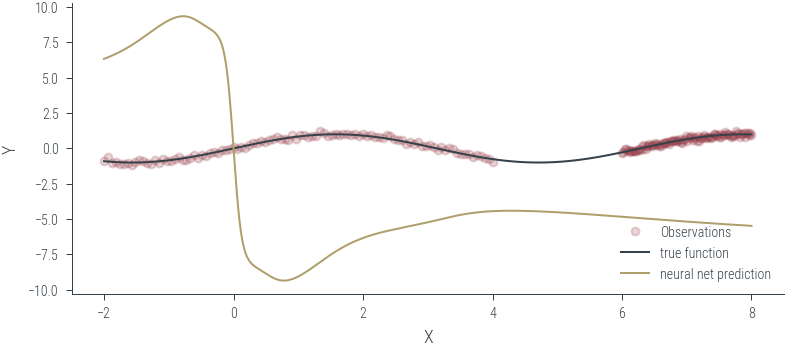

In [12]:
# Plot the untrained model
plot_predictions(test_x.cpu(), y_hat_untrained)

In [13]:
# Modify the train function to pass the dropout flag and dropout probability
def train(params, opt, fwd_func, x_train, y_train, epochs=1000, dropout=False, p=0.0):
    for i in range(epochs):
        y_hat = fwd_func(x_train, params, p)  # Pass the dropout flag and probability to fwd_func
        loss = F.mse_loss(y_hat, y_train)
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        if i % 300 == 0:
            print(f"Epoch {i}, loss {loss.item():.3f}")
    return params

In [14]:
parameters = init_params()

# Continue with optimizer
optimizer = torch.optim.Adam(parameters, lr=3e-4)

trained_params = train(parameters, optimizer, mlp, train_x, train_y, epochs=6000, dropout=False, p=0.0)

Epoch 0, loss 44.319
Epoch 300, loss 0.145
Epoch 600, loss 0.013
Epoch 900, loss 0.011
Epoch 1200, loss 0.010
Epoch 1500, loss 0.009
Epoch 1800, loss 0.009
Epoch 2100, loss 0.008
Epoch 2400, loss 0.008
Epoch 2700, loss 0.008
Epoch 3000, loss 0.008
Epoch 3300, loss 0.008
Epoch 3600, loss 0.008
Epoch 3900, loss 0.008
Epoch 4200, loss 0.007
Epoch 4500, loss 0.007
Epoch 4800, loss 0.007
Epoch 5100, loss 0.007
Epoch 5400, loss 0.007
Epoch 5700, loss 0.007


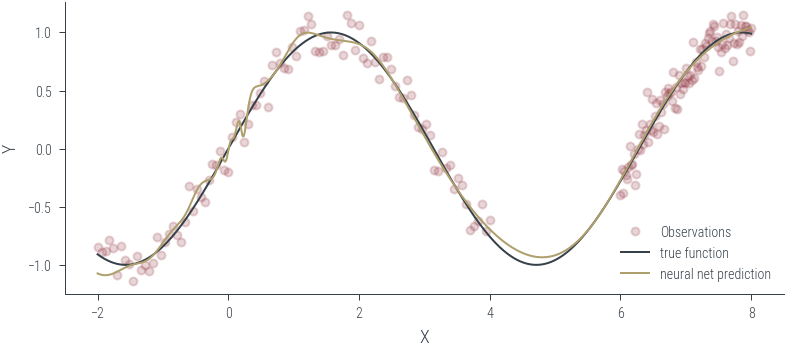

In [15]:
# Plot the trained model
with torch.no_grad():
    y_hat_trained = mlp(test_x, trained_params).ravel()
# Detach and convert to numpy
y_hat_trained = y_hat_trained.cpu().detach().numpy()

plot_predictions(test_x.cpu(), y_hat_trained)

In [16]:
### Now adding dropout to the model by manually masking the activations
W1, b1, W2, b2, W3, b3 = parameters
h1 = torch.relu(test_x @ W1 + b1)
h1.shape


torch.Size([1000, 100])

In [17]:
# probability of dropping out each neuron
p = 0.2

In [18]:
mask = torch.rand_like(h1) > p
mask.shape

torch.Size([1000, 100])

In [19]:
h1.shape

torch.Size([1000, 100])

In [20]:
mask.sum()

tensor(80090, device='cuda:0')

In [21]:
mask.numel()

100000

In [22]:
masked_activations = h1 * mask
masked_activations.shape

torch.Size([1000, 100])

In [23]:
pd.DataFrame(masked_activations.cpu().detach().numpy()).head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.609623,1.401517,0.0,0.0,0.0,0.0,0.000000,2.087857,0.186961,0.0,...,0.0,0.0,0.486637,0.063073,0.0,0.0,2.293107,0.0,3.575748,0.0
1,0.606508,1.394354,0.0,0.0,0.0,0.0,2.832026,2.077628,0.186020,0.0,...,0.0,0.0,0.484201,0.000000,0.0,0.0,2.282268,0.0,3.558007,0.0
2,0.000000,1.387191,0.0,0.0,0.0,0.0,2.817904,0.000000,0.185078,0.0,...,0.0,0.0,0.481764,0.062373,0.0,0.0,2.271428,0.0,3.540266,0.0
3,0.600278,1.380028,0.0,0.0,0.0,0.0,2.803782,2.057170,0.000000,0.0,...,0.0,0.0,0.000000,0.062023,0.0,0.0,2.260589,0.0,3.522524,0.0
4,0.597163,1.372866,0.0,0.0,0.0,0.0,2.789659,2.046941,0.183194,0.0,...,0.0,0.0,0.476892,0.061673,0.0,0.0,2.249750,0.0,3.504783,0.0


In [24]:
pd.DataFrame(h1.cpu().detach().numpy()).head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.609623,1.401517,0.0,0.0,0.0,0.0,2.846148,2.087857,0.186961,0.0,...,0.0,0.0,0.486637,0.063073,0.0,0.0,2.293107,0.0,3.575748,0.0
1,0.606508,1.394354,0.0,0.0,0.0,0.0,2.832026,2.077628,0.186020,0.0,...,0.0,0.0,0.484201,0.062723,0.0,0.0,2.282268,0.0,3.558007,0.0
2,0.603393,1.387191,0.0,0.0,0.0,0.0,2.817904,2.067399,0.185078,0.0,...,0.0,0.0,0.481764,0.062373,0.0,0.0,2.271428,0.0,3.540266,0.0
3,0.600278,1.380028,0.0,0.0,0.0,0.0,2.803782,2.057170,0.184136,0.0,...,0.0,0.0,0.479328,0.062023,0.0,0.0,2.260589,0.0,3.522524,0.0
4,0.597163,1.372866,0.0,0.0,0.0,0.0,2.789659,2.046941,0.183194,0.0,...,0.0,0.0,0.476892,0.061673,0.0,0.0,2.249750,0.0,3.504783,0.0


In [25]:
pd.DataFrame(mask.cpu().detach().numpy()).head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,True,True,True,True,True,True,False,True,True,True,...,False,True,True,True,True,False,True,True,True,True
1,True,True,False,True,True,True,True,True,True,True,...,True,True,True,False,True,False,True,True,True,True
2,False,True,True,False,True,True,True,False,True,True,...,True,True,True,True,False,True,True,True,True,True
3,True,True,True,True,True,True,True,True,False,True,...,True,True,False,True,True,True,True,True,True,False
4,True,True,False,True,True,True,True,True,True,True,...,True,True,True,True,False,True,True,True,True,False


In [26]:
### Rewriting the model with dropout

def mlp_dropout(x, params, p=0.0, training=True):
    W1, b1, W2, b2, W3, b3 = params
    h1 = torch.tanh(x @ W1 + b1)
    #h2 = torch.sin(h1 @ W2 + b2)
    #h3 = h2 @ W3 + b3
    #return h3
    if training:
        # probability of dropping out each neuron
        mask = torch.rand_like(h1) > p
        h1 = h1 * mask
        # scale activations to account for dropout
        #h1 = h1 / (1 - p)
    h2 = torch.tanh(h1 @ W2 + b2)
    if training:
        # probability of dropping out each neuron
        mask = torch.rand_like(h2) > p
        h2 = h2 * mask
        # scale activations to account for dropout
        #h2 = h2 / (1 - p)
    h3 = h2 @ W3 + b3
    return h3.ravel()

In [27]:
# Train the model
p = 0.1
parameters = init_params()

# Continue with optimizer
optimizer = torch.optim.Adam(parameters, lr=3e-4)
trained_params = train(parameters, optimizer, mlp_dropout, train_x, train_y, epochs=12000, dropout=True, p=p)

Epoch 0, loss 26.437
Epoch 300, loss 6.967
Epoch 600, loss 5.303
Epoch 900, loss 4.514
Epoch 1200, loss 3.377
Epoch 1500, loss 4.556
Epoch 1800, loss 4.172
Epoch 2100, loss 3.170
Epoch 2400, loss 2.624
Epoch 2700, loss 3.431
Epoch 3000, loss 2.385
Epoch 3300, loss 2.678
Epoch 3600, loss 2.116
Epoch 3900, loss 1.699
Epoch 4200, loss 1.847
Epoch 4500, loss 1.495
Epoch 4800, loss 1.916
Epoch 5100, loss 1.694
Epoch 5400, loss 1.220
Epoch 5700, loss 1.123
Epoch 6000, loss 0.807
Epoch 6300, loss 1.207
Epoch 6600, loss 0.997
Epoch 6900, loss 0.940
Epoch 7200, loss 0.820
Epoch 7500, loss 0.484
Epoch 7800, loss 0.577
Epoch 8100, loss 0.447
Epoch 8400, loss 0.416
Epoch 8700, loss 0.390
Epoch 9000, loss 0.349
Epoch 9300, loss 0.264
Epoch 9600, loss 0.238
Epoch 9900, loss 0.207
Epoch 10200, loss 0.180
Epoch 10500, loss 0.211
Epoch 10800, loss 0.174
Epoch 11100, loss 0.172
Epoch 11400, loss 0.153
Epoch 11700, loss 0.119


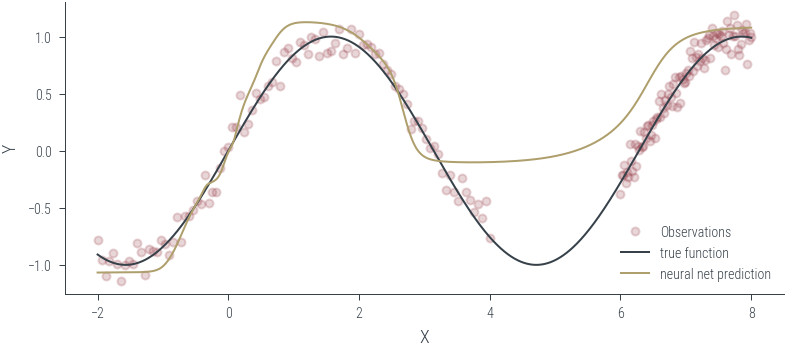

In [28]:
# Predictions with dropout
with torch.no_grad():
    y_hat_dropout = mlp_dropout(test_x, trained_params, training=False).ravel()

# Detach and convert to numpy
y_hat_dropout = y_hat_dropout.cpu().detach().numpy()

plot_predictions(test_x.cpu(), y_hat_dropout)

    

In [29]:
# Get the predictions for the test set with dropout set to True

preds = []
for i in range(100):
    with torch.no_grad():
        y_hat_dropout = mlp_dropout(test_x, trained_params, training=True, p=p).ravel()
    # Detach and convert to numpy
    y_hat_dropout = y_hat_dropout.cpu().detach().numpy()
    preds.append(y_hat_dropout)

In [30]:
# Plot MC dropout predictions

preds = np.array(preds)
preds.shape

(100, 1000)

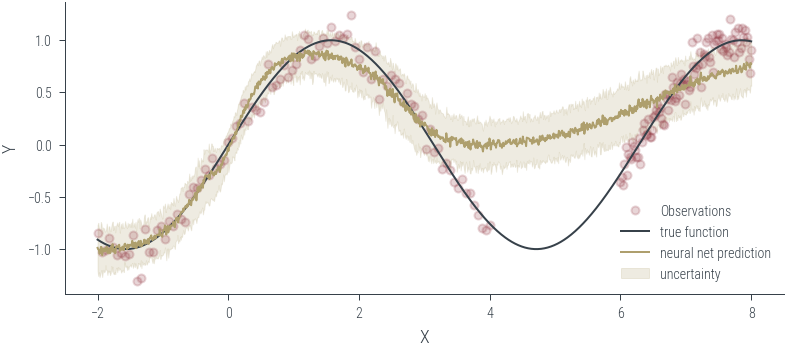

In [31]:
# Plot mean and variance of MC dropout predictions

mean = preds.mean(axis=0)
std = preds.std(axis=0)

def plot_predictions_with_uncertainty(x_test, y_preds, y_std):
    def add_predictions(ax):
        ax.plot(x_test, y_preds, 'C2', label='neural net prediction')
        ax.fill_between(x_test.ravel(), y_preds - y_std, y_preds + y_std, alpha=0.2, color='C2', label='uncertainty')

    plot_generic(add_predictions)

plot_predictions_with_uncertainty(test_x.cpu(), mean, std)


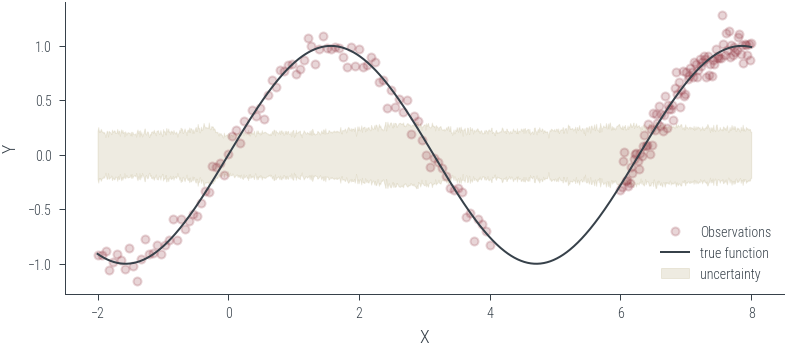

In [32]:
# Just plot the uncertainty

def plot_uncertainty(x_test, y_std):
    def add_predictions(ax):
        ax.fill_between(x_test.ravel(), -y_std, y_std, alpha=0.2, color='C2', label='uncertainty')

    plot_generic(add_predictions)
    
plot_uncertainty(test_x.cpu(), std)

In [53]:
# We now instead using nn.Dropout and nn.Linear from PyTorch

class DropoutMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim, p=0.0):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, output_dim)
        self.p = p
        
    def forward(self, x):
        x = F.tanh(self.fc1(x))
        x = F.dropout(x, p=self.p, training=self.training)
        x = F.tanh(self.fc2(x))
        x = F.dropout(x, p=self.p, training=self.training)
        x = self.fc3(x)
        return x.ravel()



In [54]:
# Train the model
p = 0.1
model = DropoutMLP(input_dim, hidden_l1_dim, hidden_l2_dim, 1, p=p)

model = model.to(device)

# Continue with optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

In [55]:
# Train the model
for i in range(12000):
    y_hat = model(train_x)
    loss = F.mse_loss(y_hat, train_y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if i % 300 == 0:
        print(f"Epoch {i}, loss {loss.item():.3f}")

Epoch 0, loss 0.381
Epoch 300, loss 0.119
Epoch 600, loss 0.090
Epoch 900, loss 0.068
Epoch 1200, loss 0.048
Epoch 1500, loss 0.043
Epoch 1800, loss 0.037
Epoch 2100, loss 0.037
Epoch 2400, loss 0.029
Epoch 2700, loss 0.033
Epoch 3000, loss 0.029
Epoch 3300, loss 0.026
Epoch 3600, loss 0.027
Epoch 3900, loss 0.025
Epoch 4200, loss 0.026
Epoch 4500, loss 0.019
Epoch 4800, loss 0.028
Epoch 5100, loss 0.023
Epoch 5400, loss 0.021
Epoch 5700, loss 0.021
Epoch 6000, loss 0.022
Epoch 6300, loss 0.022
Epoch 6600, loss 0.019
Epoch 6900, loss 0.024
Epoch 7200, loss 0.017
Epoch 7500, loss 0.020
Epoch 7800, loss 0.018
Epoch 8100, loss 0.016
Epoch 8400, loss 0.018
Epoch 8700, loss 0.020
Epoch 9000, loss 0.018
Epoch 9300, loss 0.020
Epoch 9600, loss 0.018
Epoch 9900, loss 0.015
Epoch 10200, loss 0.018
Epoch 10500, loss 0.020
Epoch 10800, loss 0.017
Epoch 11100, loss 0.018
Epoch 11400, loss 0.016
Epoch 11700, loss 0.015


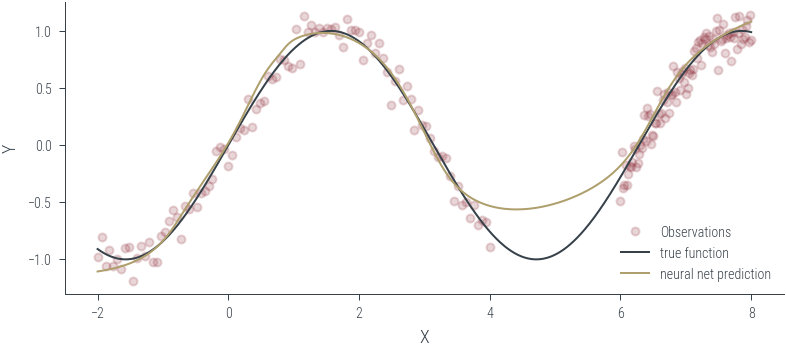

In [41]:
# Now at test time we need to set the model to eval mode
model.eval()

# Predictions with dropout
with torch.no_grad():
    y_hat_dropout = model(test_x).ravel()
    
# Detach and convert to numpy
y_hat_dropout = y_hat_dropout.cpu().detach().numpy()

plot_predictions(test_x.cpu(), y_hat_dropout)


In [47]:
# Instead we will now run multiple forward passes with dropout enabled
# Set model to train mode
model.train()
preds = []
for i in range(100):
    with torch.no_grad():
        y_hat_dropout = model(test_x).ravel()
    # Detach and convert to numpy
    y_hat_dropout = y_hat_dropout.cpu().detach().numpy()
    preds.append(y_hat_dropout)


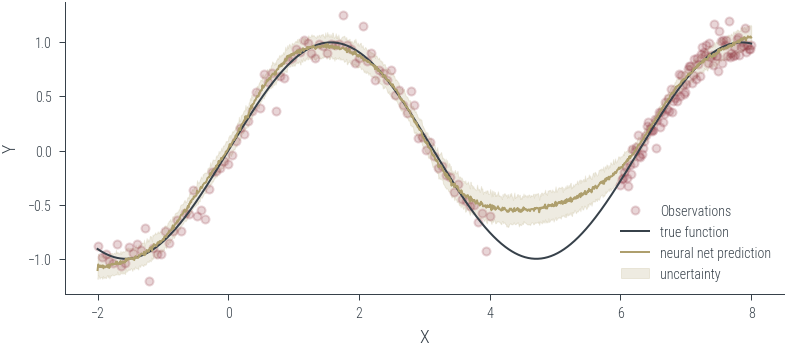

In [48]:
# Plot MC dropout predictions
preds = np.array(preds)

mean = preds.mean(axis=0)
std = preds.std(axis=0)

plot_predictions_with_uncertainty(test_x.cpu(), mean, std)

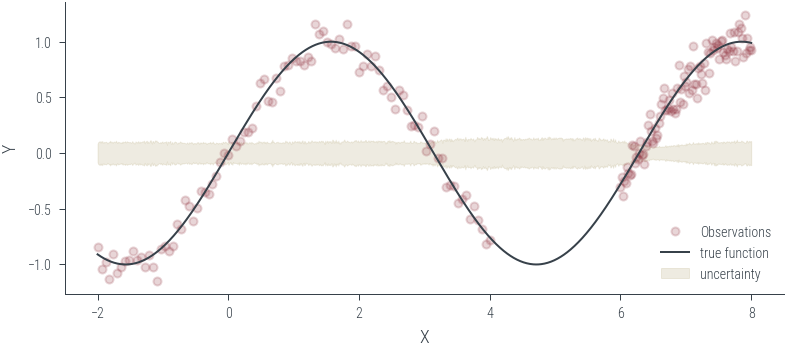

In [49]:
# Just plot the uncertainty

plot_uncertainty(test_x.cpu(), std)